# 参考自Triton官方文档


Vector Addition
===============

In this tutorial, you will write a simple vector addition using Triton.

In doing so, you will learn about:

* The basic programming model of Triton.

* The `triton.jit` decorator, which is used to define Triton kernels.

* The best practices for validating and benchmarking your custom ops against native reference implementations.

In [1]:
import torch
import triton
import triton.language as tl
import my_cuda_ops

In [ ]:
@triton.jit
def vector_add_kernel(
        x_ptr,  # 第一个向量的指针
        y_ptr,  # 第二个向量的指针
        output_ptr,  # 输出向量的指针
        n_elements,  # 向量的大小
        BLOCK_SIZE: tl.constexpr,  # 每个 block 的大小
):
    # 获取当前程序的全局索引
    pid = tl.program_id(axis=0)

    # 计算当前 block 的起始和结束索引
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)

    # 创建一个掩码以防止越界访问
    mask = offsets < n_elements

    # 从全局内存加载数据
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)

    # 执行向量加法
    output = x + y
    # 将结果存储回全局内存
    tl.store(output_ptr + offsets, output, mask=mask)

In [4]:
# Let's also declare a helper function to (1) allocate the `z` tensor
# and (2) enqueue the above kernel with appropriate grid/block sizes:
# add by triton
def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    assert x.is_cuda and y.is_cuda
    assert x.is_contiguous() and y.is_contiguous()
    assert x.shape == y.shape

    # 创建输出张量
    output = torch.empty_like(x)
    # 获取向量的大小
    n_elements = x.numel()
    # 定义 block 的大小
    BLOCK_SIZE = 1024

    # 计算 grid 的大小
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
    # 启动 kernel
    vector_add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=BLOCK_SIZE)
    return output

# add by cuda
def add_cuda(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    assert x.is_cuda and y.is_cuda
    assert x.is_contiguous() and y.is_contiguous()
    assert x.shape == y.shape
    n_elements = x.numel()
    # 创建输出张量
    output = torch.empty_like(x)
    my_cuda_ops.add_cuda(x, y, output, n_elements)
    return output

In [5]:
# We can now use the above function to compute the element-wise sum of two `torch.tensor` objects and test its correctness:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = x + y
output_triton = add(x, y)
output_cuda = add_cuda(x, y)
print(output_torch)
print(output_triton)
print(output_cuda)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')
print(f'The maximum difference between torch and cuda is '
      f'{torch.max(torch.abs(output_torch - output_cuda))}')

tensor([1.3713, 1.3076, 0.4940,  ..., 1.3374, 1.4960, 0.9115], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 1.3374, 1.4960, 0.9115], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 1.3374, 1.4960, 0.9115], device='cuda:0')
The maximum difference between torch and triton is 0.0
The maximum difference between torch and cuda is 0.0


In [6]:
# Benchmark
# ---------
#
# We can now benchmark our custom op on vectors of increasing sizes to get a sense of how it does relative to PyTorch.
# To make things easier, Triton has a set of built-in utilities that allow us to concisely plot the performance of our custom ops.
# for different problem sizes.


@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'cuda'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'CUDA'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    if provider == 'cuda':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add_cuda(x, y), quantiles=quantiles)
    gbps = lambda ms : 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

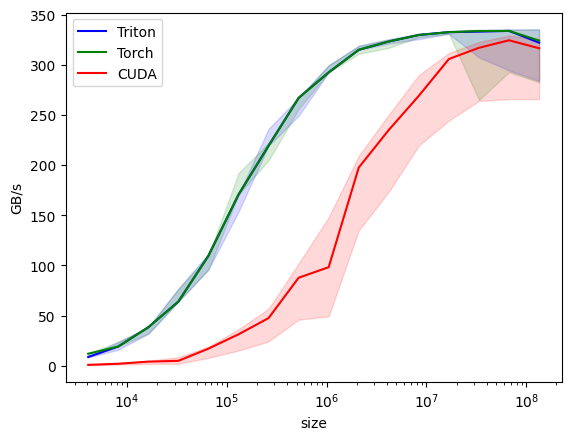

vector-add-performance:
           size      Triton       Torch        CUDA
0        4096.0    8.727273   12.000000    0.905660
1        8192.0   19.200000   19.200000    2.000000
2       16384.0   38.400001   38.400001    4.119343
3       32768.0   63.999998   63.999998    4.923077
4       65536.0  109.714284  109.714284   17.066666
5      131072.0  170.666661  170.666661   31.346940
6      262144.0  219.428568  219.428568   47.535785
7      524288.0  267.130429  267.130429   87.771426
8     1048576.0  292.571431  292.571431   98.303995
9     2097152.0  315.076934  315.076934  197.645650
10    4194304.0  323.368435  323.368435  235.177028
11    8388608.0  329.879196  329.879196  269.256863
12   16777216.0  332.670041  332.670041  305.922825
13   33554432.0  333.233892  333.799659  317.081721
14   67108864.0  333.941401  333.941401  324.569534
15  134217728.0  322.209139  324.268408  316.630901


In [7]:
# We can now run the decorated function above. Pass `print_data=True` to see the performance number, `show_plots=True` to plot them, and/or
# `save_path='/path/to/results/' to save them to disk along with raw CSV data:
benchmark.run(print_data=True, show_plots=True)